# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Общее описание решения
При анализе данных, первое что бросается в глаза это дисбаланс классов.
Первое желание было сгенерировать с помощью аугментации доподнительные данные используя популярные библиотеки (например albumentations).
Идея была в увеличении самого датасета за счет генерации аугментированных изображений таким образом, чтобы в тренировочном датасете для каждого класса было не менее например по 1000 примеров.
Однако при дальнейшем изучении вопроса вяснилось, что подход в корне другой:
1. Подсчитываем кол-во данных для каждого класса через Counter 
2. Определяем для каждого класса его вес (1/кол-во сэмплов класса). Используя WeightedRandomSampler формируем сэмплер, который будет выдавать уравновешенное распределение данных по классам.
3. Чтобы разнообразить данные по "редким" классам (где мало данных) испоьлзуем аугментацию. По сути аугментация и трансформация делается на лету, т.е. при использовании даталоудера запрашиваем данные согласно нашему сэмплеру (грубо говоря по правилам которые опредлены сэмплере).

Плюс такого подхода в простоте реализации. Минус в том что аугментация на лету делается для всех классов, в том числе для которых достаточный объем обучающих данных, по хорошему для таких классов надо использовать оригинальные данные без аугментации.



Дополнительно относительно базовой модели добавлена батчнормализация в каждом слое

Импортируем необходимые библиотеки

In [446]:
from multiprocessing.pool import ThreadPool
from pathlib import Path

import numpy as np
import pandas as pd
from collections import Counter

import PIL
from PIL import Image
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision
from torchvision import transforms


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage import io

from tqdm import tqdm, tqdm_notebook

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


Определяем наличие поддержки GPU

In [447]:
# !nvidia-smi
torch.cuda.is_available()
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    # работаем на процессоре
    print('CUDA не доступна.  Работаем на CPU ...')
    DEVICE = torch.device("cpu")    
else:
    # работаем на видеокарте
    print('CUDA доступна! Работаем на GPU ...')
    DEVICE = torch.device("cuda")

CUDA доступна! Работаем на GPU ...


In [448]:
# # Для колаба монтируем диск, для локального запуска это необходмио закомментировать 
# from google.colab import drive
# drive.mount('/content/gdrive/')

Объявляем константы и пути

In [449]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
PATH = "simpsons_datasets/"
# PATH = "gdrive/MyDrive/DLS/simpsons/"
TRAIN_DIR = Path(PATH+'train_dataset')
TEST_DIR = Path(PATH+'test_dataset')


Загружаем данные

In [450]:
# загрузка данных
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [470]:
# np.random.randint(70,100)/100
# import random
# random.randrange(7,1)

0.87

Определяем класс SimpsonsDataset (наследуем от Dataset).
В классе SimpsonsDataset определяем необходмые процедуры по загрузке и предобработке данных. Аугментация производится именно здесь для каждого запрошенного объекта.

In [618]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
#         if self.mode == "train": 
#             transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                 transforms.Compose([
#                     transforms.Resize(size=300, max_size=401),
#                     transforms.CenterCrop(size=300),
#                     transforms.RandomCrop(250),
#                 ]),
#                 transforms.RandomRotation(degrees=(-30, 30)),
#                 transforms.RandomHorizontalFlip(p=0.5),
#             ])

        
        random_rescale_size = int(RESCALE_SIZE*np.random.randint(70,100)/100)

        if self.mode == "train": 
#             random_augmentations = transforms.RandomChoice([
# #             random_augmentations = transforms.Compose([
#                 transforms.Compose([
#                     transforms.Resize(size=random_rescale_size, max_size=random_rescale_size),
#                     transforms.CenterCrop(size=RESCALE_SIZE),
#                     transforms.RandomCrop(RESCALE_SIZE),
#                 ]),
#                 transforms.RandomRotation(degrees=(-30, 30)),
#                 transforms.RandomHorizontalFlip(p=0.8),
# #                 transforms.RandomHorizontalFlip(p=0.5),
#             ])
#             transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                 random_augmentations,
#             ])
            min_random_rescale_size = int(RESCALE_SIZE*np.random.randint(8,10)/10)
            max_random_rescale_size = int(RESCALE_SIZE*np.random.randint(10,14)/10)
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.RandomChoice([
                    transforms.Compose([
                        transforms.Resize(size=min_random_rescale_size, max_size=min_random_rescale_size+1),
                        transforms.CenterCrop(size=RESCALE_SIZE),
                        transforms.RandomCrop(RESCALE_SIZE),
                    ]),        
                    transforms.Compose([
                        transforms.Resize(size=max_random_rescale_size, max_size=max_random_rescale_size+1),
                        transforms.CenterCrop(size=RESCALE_SIZE),
                        transforms.RandomCrop(RESCALE_SIZE),
                    ]),
                ]),
                transforms.RandomRotation(degrees=(-25, 25)),
                transforms.RandomHorizontalFlip(p=0.5),                
            ])
        else:        
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
        

#         transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# #             transforms.functional.adjust_gamma(gamma = uniform(0.5, 5.0)),
#         ])
        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

Определяем методы по визуализации данных. 
Обычный метод визуализации загруженных изображений и визуализации изображений в виде тензоров

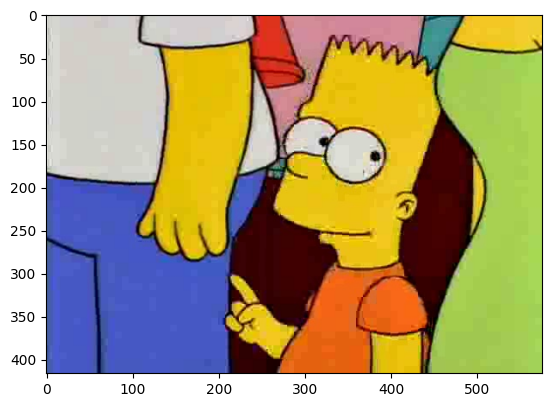

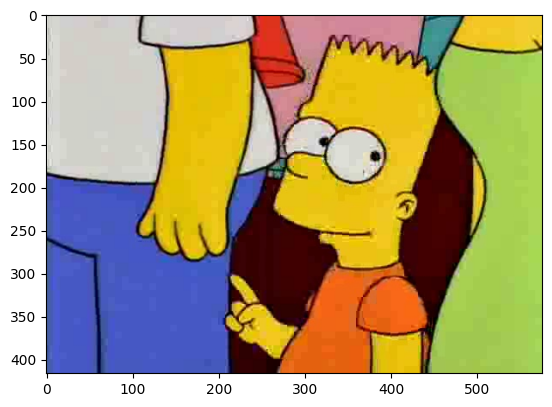

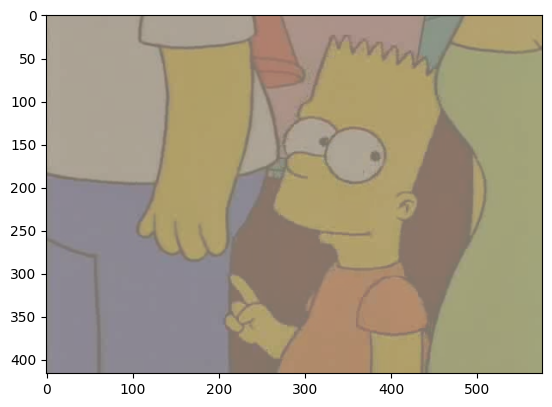

In [619]:
def visualize(image):
    """ Метод визуализации изображения"""
    plt.figure()
    plt.imshow(image)
    return plt

def visualize_tensor(inp):
    """
    Метод визуализации для тензоров
    При переводе в тензор каналы цветов перемещены на первую позицию, 
    а при обычной загрузке каналы цветов расположены в конце.
    Поэтому перед визуализацией делается доп. преобразование
    """
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure()
    plt.imshow(inp)

def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow метод визуализации для тензоров с нормализацией. Метод взят из бейзлайна"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure()
    plt_ax.imshow(inp)
    plt.rc('font', size=10) 
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

    
image = Image.open(train_val_files[2000])
image.load()

visualize(image)
visualize_tensor(transforms.ToTensor()(image))
imshow(transforms.ToTensor()(image))

### Подготовливаем данные

Из тренировочных данных выделяем валидационные данные

In [620]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [631]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Проверка загруженных данных

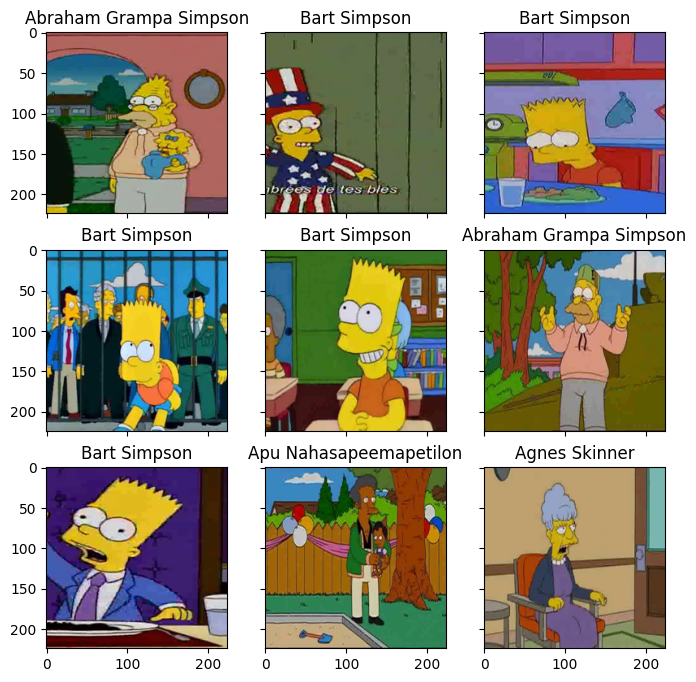

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [622]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

### Построение модели

Сама модель:
1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

На каждом конв-слое добавлена батчнормализация.
В качестве активации используется LeakyReLU

In [623]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=2)
        )
#         self.drop_out = nn.Dropout(p=0.3)
#         self.fl_1 = nn.Linear(96 * 5 * 5, 1000)
#         self.out = nn.Linear(1000, n_classes)
        self.out = nn.Linear(96 * 5 * 5, n_classes)
        
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
#         x = self.fl_1(self.drop_out(x))
#         logits = self.out(self.drop_out(x))
        logits = self.out(x)
        return logits

Обучение модели на тренировочных данных

In [624]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader, position = 0, leave=True):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Прогон модели на валидационных данных

In [625]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

С целью борьбы с дисбалансом классов изменяется сэмплер DataLoader.

Метод для формивраония правила выборки данных (сэмплеров) на основе WeightedRandomSampler

In [626]:
# Формируем распределение данных для выгрузки из DataLoader сбалансированных данных
def create_sampler(ds):
    print(len(ds))
    class_count = Counter(ds.labels)
    class_weights = {name: 1/cnt for name, cnt in class_count.items()}

    sample_weights = [0] * len(ds)
    for i, label in enumerate(ds.labels):
        class_weight = class_weights[label]
        sample_weights[i] = class_weight
    # Максимальное кол-во объкетов = максимальное кол-во записей среди всех классов в трейне * на кол-во классов  
    N_count = max(class_count.values()) * len(class_count)

    sampler = WeightedRandomSampler(sample_weights, num_samples=N_count, replacement=True)
    return sampler

Главный цикл обучения по эпохам

In [627]:
def train(train_dataset, val_dataset, model, epochs, batch_size):
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=create_sampler(train_dataset))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=create_sampler(val_dataset))
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

Предиктовый метод для предсказаний по тестовым данным

In [628]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Итоговая структура модели

In [629]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(

In [630]:
# Модель исправлена: добавлены Батч, без дропаута +  Аугментация
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=6, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [14:27<00:00,  1.27it/s]


loss 0.9690575294264867


epoch:  17%|█▋        | 1/6 [17:15<1:26:17, 1035.57s/it]


Epoch 001 train_loss: 0.9691     val_loss 1.4229 train_acc 0.7478 val_acc 0.7163


100%|██████████| 1106/1106 [13:41<00:00,  1.35it/s]


loss 0.41285615821546284


epoch:  33%|███▎      | 2/6 [33:29<1:06:37, 999.48s/it] 


Epoch 002 train_loss: 0.4129     val_loss 1.2075 train_acc 0.8876 val_acc 0.7551


100%|██████████| 1106/1106 [13:36<00:00,  1.35it/s]


loss 0.2869655299169515


epoch:  50%|█████     | 3/6 [49:35<49:12, 984.26s/it]  


Epoch 003 train_loss: 0.2870     val_loss 1.3929 train_acc 0.9202 val_acc 0.7452


100%|██████████| 1106/1106 [13:34<00:00,  1.36it/s]


loss 0.242006484325143


epoch:  67%|██████▋   | 4/6 [1:05:40<32:32, 976.45s/it]


Epoch 004 train_loss: 0.2420     val_loss 1.5051 train_acc 0.9332 val_acc 0.7703


100%|██████████| 1106/1106 [13:33<00:00,  1.36it/s]


loss 0.2078027298680097


epoch:  83%|████████▎ | 5/6 [1:21:44<16:12, 972.11s/it]


Epoch 005 train_loss: 0.2078     val_loss 1.5348 train_acc 0.9414 val_acc 0.7699


100%|██████████| 1106/1106 [13:35<00:00,  1.36it/s]


loss 0.1850106753796565


epoch: 100%|██████████| 6/6 [1:37:50<00:00, 978.36s/it]


Epoch 006 train_loss: 0.1850     val_loss 1.5224 train_acc 0.9490 val_acc 0.7638


In [523]:
# Без аугментации но модель исправлена: добавлены Батч, без дропаута
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=6, batch_size=64)

15699
5234


epoch:   0%|          | 0/6 [00:00<?, ?it/s]

x size: 224
x[0] size: 224


AssertionError: 

In [376]:
# Без аугментации но модель исправлена: добавлены Батч + Дроп, без доп слоя
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=6, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [11:19<00:00,  1.63it/s]


loss 0.719167481614459


epoch:  17%|█▋        | 1/6 [13:47<1:08:58, 827.67s/it]


Epoch 001 train_loss: 0.7192     val_loss 1.8316 train_acc 0.8136 val_acc 0.6171


100%|██████████| 1106/1106 [11:09<00:00,  1.65it/s]


loss 0.17595472198728454


epoch:  33%|███▎      | 2/6 [27:24<54:45, 821.29s/it]  


Epoch 002 train_loss: 0.1760     val_loss 2.0486 train_acc 0.9529 val_acc 0.6535


100%|██████████| 1106/1106 [11:06<00:00,  1.66it/s]


loss 0.11805295196372163


epoch:  50%|█████     | 3/6 [40:58<40:53, 817.82s/it]


Epoch 003 train_loss: 0.1181     val_loss 2.5686 train_acc 0.9671 val_acc 0.6420


100%|██████████| 1106/1106 [11:07<00:00,  1.66it/s]


loss 0.08686913435004281


epoch:  67%|██████▋   | 4/6 [54:33<27:13, 816.65s/it]


Epoch 004 train_loss: 0.0869     val_loss 2.5733 train_acc 0.9750 val_acc 0.6074


100%|██████████| 1106/1106 [11:07<00:00,  1.66it/s]


loss 0.0788322827594304


epoch:  83%|████████▎ | 5/6 [1:08:07<13:36, 816.00s/it]


Epoch 005 train_loss: 0.0788     val_loss 2.4970 train_acc 0.9781 val_acc 0.6540


100%|██████████| 1106/1106 [11:06<00:00,  1.66it/s]


loss 0.05886744420836597


epoch: 100%|██████████| 6/6 [1:21:41<00:00, 816.99s/it]


Epoch 006 train_loss: 0.0589     val_loss 3.1035 train_acc 0.9827 val_acc 0.6241


In [330]:
#ОШИБКА была в модели  Без аугментации но модель исправлена: добавлены Батч + Дроп + Доп полносвязный слой
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=6, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [16:34<00:00,  1.11it/s]


loss 0.12679830681730506


epoch:  14%|█▍        | 1/7 [18:52<1:53:16, 1132.78s/it]


Epoch 001 train_loss: 0.1268     val_loss 1.9892 train_acc 0.9630 val_acc 0.7243


100%|██████████| 1106/1106 [16:38<00:00,  1.11it/s]


loss 0.11241567630804093


epoch:  29%|██▊       | 2/7 [37:56<1:34:55, 1139.06s/it]


Epoch 002 train_loss: 0.1124     val_loss 2.1339 train_acc 0.9675 val_acc 0.7253


100%|██████████| 1106/1106 [16:31<00:00,  1.12it/s]


loss 0.1017888754523238


epoch:  43%|████▎     | 3/7 [56:52<1:15:50, 1137.74s/it]


Epoch 003 train_loss: 0.1018     val_loss 1.8269 train_acc 0.9711 val_acc 0.7637


100%|██████████| 1106/1106 [16:35<00:00,  1.11it/s]


loss 0.09704668221312833


epoch:  57%|█████▋    | 4/7 [1:15:41<56:42, 1134.13s/it]


Epoch 004 train_loss: 0.0970     val_loss 2.2467 train_acc 0.9724 val_acc 0.7253


100%|██████████| 1106/1106 [16:31<00:00,  1.12it/s]


loss 0.09346881685484597


epoch:  71%|███████▏  | 5/7 [1:34:37<37:49, 1134.89s/it]


Epoch 005 train_loss: 0.0935     val_loss 2.0810 train_acc 0.9734 val_acc 0.7250


100%|██████████| 1106/1106 [16:37<00:00,  1.11it/s]


loss 0.0824458020135757


epoch:  86%|████████▌ | 6/7 [1:53:39<18:57, 1137.50s/it]


Epoch 006 train_loss: 0.0824     val_loss 2.0515 train_acc 0.9766 val_acc 0.7378


100%|██████████| 1106/1106 [16:34<00:00,  1.11it/s]


loss 0.07875420389047631


epoch: 100%|██████████| 7/7 [2:12:38<00:00, 1136.93s/it]


Epoch 007 train_loss: 0.0788     val_loss 2.3316 train_acc 0.9777 val_acc 0.7087


In [296]:
# Исправленая аугментация с базовой моделью
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=7, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [17:48<00:00,  1.04it/s]


loss 1.333474821431404


epoch:  14%|█▍        | 1/7 [20:32<2:03:17, 1232.94s/it]


Epoch 001 train_loss: 1.3335     val_loss 1.7437 train_acc 0.6522 val_acc 0.6045


100%|██████████| 1106/1106 [17:13<00:00,  1.07it/s]


loss 0.4566793059509893


epoch:  29%|██▊       | 2/7 [40:15<1:40:16, 1203.31s/it]


Epoch 002 train_loss: 0.4567     val_loss 1.9612 train_acc 0.8772 val_acc 0.6559


100%|██████████| 1106/1106 [16:59<00:00,  1.09it/s]


loss 0.3066821317083627


epoch:  43%|████▎     | 3/7 [59:41<1:19:05, 1186.41s/it]


Epoch 003 train_loss: 0.3067     val_loss 1.7010 train_acc 0.9170 val_acc 0.6879


100%|██████████| 1106/1106 [16:56<00:00,  1.09it/s]


loss 0.22332502708737362


epoch:  57%|█████▋    | 4/7 [1:19:03<58:49, 1176.53s/it]


Epoch 004 train_loss: 0.2233     val_loss 2.2318 train_acc 0.9376 val_acc 0.7002


100%|██████████| 1106/1106 [16:50<00:00,  1.09it/s]


loss 0.1902650610433495


epoch:  71%|███████▏  | 5/7 [1:38:18<38:57, 1168.80s/it]


Epoch 005 train_loss: 0.1903     val_loss 1.8566 train_acc 0.9468 val_acc 0.7124


100%|██████████| 1106/1106 [16:51<00:00,  1.09it/s]


loss 0.16036212114418555


epoch:  86%|████████▌ | 6/7 [1:57:35<19:24, 1164.91s/it]


Epoch 006 train_loss: 0.1604     val_loss 1.8360 train_acc 0.9545 val_acc 0.7414


100%|██████████| 1106/1106 [16:58<00:00,  1.09it/s]


loss 0.1366691621328665


epoch: 100%|██████████| 7/7 [2:17:00<00:00, 1174.37s/it]


Epoch 007 train_loss: 0.1367     val_loss 2.0336 train_acc 0.9603 val_acc 0.7216


In [277]:
# Только аугментация с базовой моделью
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=7, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [13:59<00:00,  1.32it/s]


loss 1.5985145979560806


epoch:  14%|█▍        | 1/7 [16:38<1:39:50, 998.45s/it]


Epoch 001 train_loss: 1.5985     val_loss 1.2866 train_acc 0.5783 val_acc 0.6838


100%|██████████| 1106/1106 [13:58<00:00,  1.32it/s]


loss 0.6072549528125561


epoch:  29%|██▊       | 2/7 [33:17<1:23:13, 998.63s/it]


Epoch 002 train_loss: 0.6073     val_loss 1.3406 train_acc 0.8388 val_acc 0.7499


100%|██████████| 1106/1106 [13:58<00:00,  1.32it/s]


loss 0.4187232234328058


epoch:  43%|████▎     | 3/7 [49:55<1:06:33, 998.42s/it]


Epoch 003 train_loss: 0.4187     val_loss 1.3009 train_acc 0.8853 val_acc 0.7644


epoch:  43%|████▎     | 3/7 [58:56<1:18:34, 1178.70s/it]


KeyboardInterrupt: 

In [241]:
# Исправлена аугментация подкорректированны добавлены Dropout
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=7, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [13:33<00:00,  1.36it/s]


loss 1.5768940755514897


epoch:  14%|█▍        | 1/7 [16:04<1:36:27, 964.58s/it]


Epoch 001 train_loss: 1.5769     val_loss 1.3487 train_acc 0.5985 val_acc 0.6976


100%|██████████| 1106/1106 [13:23<00:00,  1.38it/s]


loss 0.6244922522815721


epoch:  29%|██▊       | 2/7 [32:16<1:20:45, 969.06s/it]


Epoch 002 train_loss: 0.6245     val_loss 1.3436 train_acc 0.8306 val_acc 0.7122


100%|██████████| 1106/1106 [14:12<00:00,  1.30it/s]


loss 0.42510750752623744


epoch:  43%|████▎     | 3/7 [49:04<1:05:46, 986.53s/it]


Epoch 003 train_loss: 0.4251     val_loss 1.4156 train_acc 0.8825 val_acc 0.7516


100%|██████████| 1106/1106 [13:26<00:00,  1.37it/s]


loss 0.3387648214230763


epoch:  57%|█████▋    | 4/7 [1:05:02<48:46, 975.59s/it]


Epoch 004 train_loss: 0.3388     val_loss 1.3546 train_acc 0.9050 val_acc 0.7593


100%|██████████| 1106/1106 [13:20<00:00,  1.38it/s]


loss 0.29807817661213454


epoch:  71%|███████▏  | 5/7 [1:20:59<32:17, 968.72s/it]


Epoch 005 train_loss: 0.2981     val_loss 1.4963 train_acc 0.9164 val_acc 0.7794


epoch:  71%|███████▏  | 5/7 [1:21:06<32:26, 973.25s/it]


KeyboardInterrupt: 

In [190]:
# Исправлена аугментация с РандомЧойз на Компосе
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=7, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [13:56<00:00,  1.32it/s]


loss 1.4751844202524234


epoch:  14%|█▍        | 1/7 [16:27<1:38:44, 987.44s/it]


Epoch 001 train_loss: 1.4752     val_loss 1.4625 train_acc 0.6118 val_acc 0.6582


100%|██████████| 1106/1106 [13:55<00:00,  1.32it/s]


loss 0.7815026170109046


epoch:  29%|██▊       | 2/7 [32:53<1:22:12, 986.60s/it]


Epoch 002 train_loss: 0.7815     val_loss 1.0952 train_acc 0.7915 val_acc 0.7450


100%|██████████| 1106/1106 [13:59<00:00,  1.32it/s]


loss 0.539120888355401


epoch:  43%|████▎     | 3/7 [49:22<1:05:50, 987.51s/it]


Epoch 003 train_loss: 0.5391     val_loss 1.1199 train_acc 0.8535 val_acc 0.7477


100%|██████████| 1106/1106 [13:53<00:00,  1.33it/s]


loss 0.43673076883536527


epoch:  57%|█████▋    | 4/7 [1:05:44<49:16, 985.52s/it]


Epoch 004 train_loss: 0.4367     val_loss 1.1261 train_acc 0.8801 val_acc 0.7562


100%|██████████| 1106/1106 [13:54<00:00,  1.33it/s]


loss 0.3804418830933521


epoch:  71%|███████▏  | 5/7 [1:22:08<32:50, 985.14s/it]


Epoch 005 train_loss: 0.3804     val_loss 1.0221 train_acc 0.8952 val_acc 0.7515


100%|██████████| 1106/1106 [13:54<00:00,  1.33it/s]


loss 0.3415944262262033


epoch:  86%|████████▌ | 6/7 [1:38:32<16:24, 984.56s/it]


Epoch 006 train_loss: 0.3416     val_loss 1.2347 train_acc 0.9052 val_acc 0.7538


100%|██████████| 1106/1106 [14:10<00:00,  1.30it/s]


loss 0.318249702854753


epoch: 100%|██████████| 7/7 [1:55:13<00:00, 987.59s/it]


Epoch 007 train_loss: 0.3182     val_loss 1.1337 train_acc 0.9120 val_acc 0.7764


In [172]:
# Без аугментации
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=7, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [09:51<00:00,  1.87it/s]


loss 1.209382969354723


epoch:  20%|██        | 1/5 [12:18<49:12, 738.24s/it]


Epoch 001 train_loss: 1.2094     val_loss 1.5517 train_acc 0.6864 val_acc 0.7178


100%|██████████| 1106/1106 [09:51<00:00,  1.87it/s]


loss 0.5471438066531409


epoch:  40%|████      | 2/5 [24:37<36:55, 738.61s/it]


Epoch 002 train_loss: 0.5471     val_loss 1.4240 train_acc 0.8535 val_acc 0.7593


100%|██████████| 1106/1106 [09:58<00:00,  1.85it/s]


loss 0.3521723548133049


epoch:  60%|██████    | 3/5 [37:02<24:43, 741.77s/it]


Epoch 003 train_loss: 0.3522     val_loss 1.3914 train_acc 0.9027 val_acc 0.7679


100%|██████████| 1106/1106 [09:59<00:00,  1.85it/s]


loss 0.2742455122835859


epoch:  80%|████████  | 4/5 [49:28<12:23, 743.55s/it]


Epoch 004 train_loss: 0.2742     val_loss 1.4822 train_acc 0.9242 val_acc 0.7925


100%|██████████| 1106/1106 [09:57<00:00,  1.85it/s]


loss 0.23202582861237525


epoch: 100%|██████████| 5/5 [1:01:52<00:00, 742.50s/it]


Epoch 005 train_loss: 0.2320     val_loss 1.3835 train_acc 0.9342 val_acc 0.7963


In [141]:
# Без бачнорма
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [10:14<00:00,  1.80it/s]


loss 1.4354027361571013


epoch:  20%|██        | 1/5 [12:42<50:48, 762.03s/it]


Epoch 001 train_loss: 1.4354     val_loss 1.3528 train_acc 0.6275 val_acc 0.6702


100%|██████████| 1106/1106 [10:16<00:00,  1.79it/s]


loss 0.5617155969739567


epoch:  40%|████      | 2/5 [25:31<38:19, 766.51s/it]


Epoch 002 train_loss: 0.5617     val_loss 1.3118 train_acc 0.8493 val_acc 0.7385


epoch:  40%|████      | 2/5 [28:32<42:49, 856.34s/it]


KeyboardInterrupt: 

In [123]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [11:11<00:00,  1.65it/s]


loss 1.1537922533331595


epoch:  20%|██        | 1/5 [14:03<56:12, 843.12s/it]


Epoch 001 train_loss: 1.1538     val_loss 1.5040 train_acc 0.7002 val_acc 0.7068


100%|██████████| 1106/1106 [09:57<00:00,  1.85it/s]


loss 0.5211893647804666


epoch:  40%|████      | 2/5 [26:32<39:23, 787.70s/it]


Epoch 002 train_loss: 0.5212     val_loss 1.4291 train_acc 0.8606 val_acc 0.7478


100%|██████████| 1106/1106 [09:49<00:00,  1.88it/s]


loss 0.3502540637594369


epoch:  60%|██████    | 3/5 [38:49<25:29, 764.68s/it]


Epoch 003 train_loss: 0.3503     val_loss 1.4493 train_acc 0.9037 val_acc 0.7689


epoch:  60%|██████    | 3/5 [40:05<26:43, 801.95s/it]


KeyboardInterrupt: 

Обучение модели

In [21]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

15699
5234


100%|██████████| 1106/1106 [35:33<00:00,  1.93s/it]


loss 1.3519130351249213


epoch:  20%|██        | 1/5 [40:43<2:42:55, 2443.79s/it]


Epoch 001 train_loss: 1.3519     val_loss 1.4882 train_acc 0.6411 val_acc 0.6349


100%|██████████| 1106/1106 [32:11<00:00,  1.75s/it]


loss 0.6534940252136812


epoch:  40%|████      | 2/5 [1:17:21<1:54:57, 2299.28s/it]


Epoch 002 train_loss: 0.6535     val_loss 1.0524 train_acc 0.8234 val_acc 0.7483


100%|██████████| 1106/1106 [33:07<00:00,  1.80s/it]


loss 0.4365165489667304


epoch:  60%|██████    | 3/5 [1:55:21<1:16:20, 2290.11s/it]


Epoch 003 train_loss: 0.4365     val_loss 0.9948 train_acc 0.8805 val_acc 0.7743


100%|██████████| 1106/1106 [32:08<00:00,  1.74s/it]


loss 0.35341798740063785


epoch:  80%|████████  | 4/5 [2:31:48<37:29, 2249.37s/it]  


Epoch 004 train_loss: 0.3534     val_loss 0.9797 train_acc 0.9026 val_acc 0.7784


100%|██████████| 1106/1106 [33:49<00:00,  1.83s/it]


loss 0.30252327139879853


epoch: 100%|██████████| 5/5 [3:10:28<00:00, 2285.76s/it]


Epoch 005 train_loss: 0.3025     val_loss 1.0833 train_acc 0.9151 val_acc 0.7603


In [632]:
loss, acc, val_loss, val_acc = zip(*history)

In [633]:
# map(cpu(), val_acc)
# val_acc[0].cpu()
# lambda i: i.cpu()
tuple([i.cpu() for i in val_acc])

(tensor(0.7163, dtype=torch.float64),
 tensor(0.7551, dtype=torch.float64),
 tensor(0.7452, dtype=torch.float64),
 tensor(0.7703, dtype=torch.float64),
 tensor(0.7699, dtype=torch.float64),
 tensor(0.7638, dtype=torch.float64))

Отображаем графики ошибки и валиадции

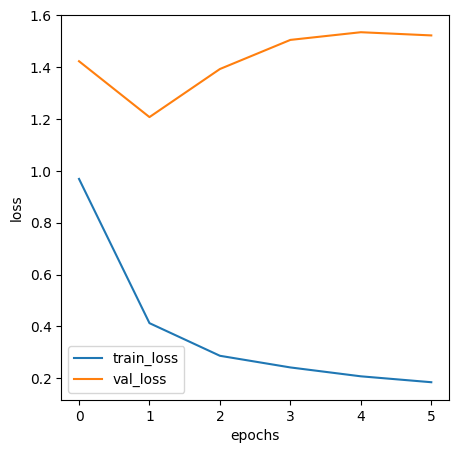

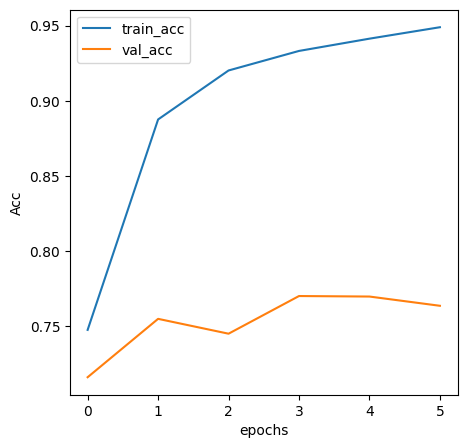

In [634]:
plt.figure(figsize=(5, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(acc, label="train_acc")
# plt.plot(val_acc, label="val_acc")
plt.plot(tuple([i.cpu() for i in val_acc]), label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("Acc")
plt.show()

Формируем прогноз по тестовым данным

In [635]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [636]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [637]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [638]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [639]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [640]:
len(y_pred)

20

Проверяем получившийся скор 

In [641]:
from sklearn.metrics import f1_score

# f1_score(actual_labels, preds_class)
f1_score(actual_labels, list(y_pred), average='micro')



0.9

Выводим примеры тестовых данных и получившихся прогнозов

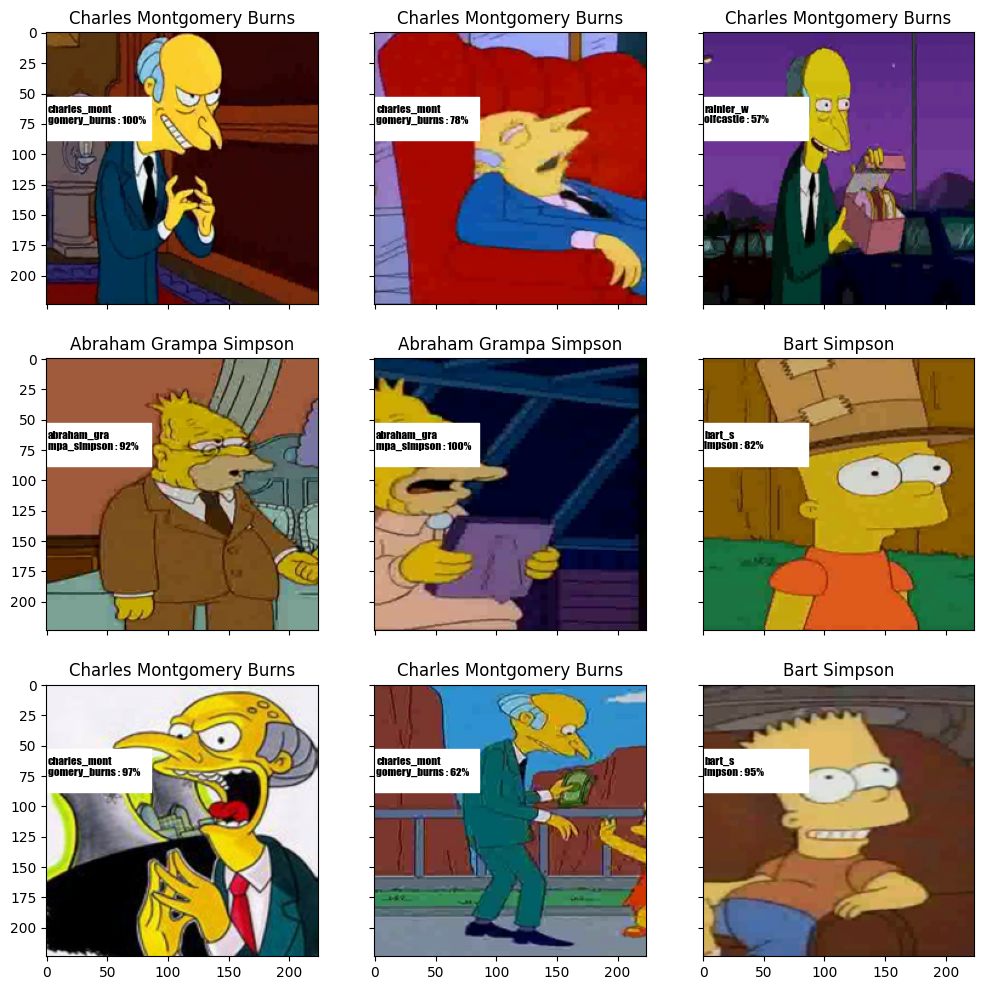

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [642]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [643]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

Формируем итоговый файл с прогнозом

In [644]:
import pandas as pd
submission_path = PATH + 'sample_submission.csv'
my_submit = pd.read_csv(submission_path)
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [645]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

In [646]:
my_submit.to_csv(PATH + 'my_submission_3.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [526]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

In [590]:




#         # для преобразования изображений в тензоры PyTorch и нормализации входа
# #         if self.mode == "train": 
# #             transform = transforms.Compose([
# #                 transforms.ToTensor(),
# #                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# #                 transforms.Compose([
# #                     transforms.Resize(size=300, max_size=401),
# #                     transforms.CenterCrop(size=300),
# #                     transforms.RandomCrop(250),
# #                 ]),
# #                 transforms.RandomRotation(degrees=(-30, 30)),
# #                 transforms.RandomHorizontalFlip(p=0.5),
# #             ])

        
#         random_rescale_size = int(RESCALE_SIZE*np.random.randint(70,100)/100)

#         if self.mode == "train": 
#             random_augmentations = transforms.RandomChoice([
# #             random_augmentations = transforms.Compose([
#                 transforms.Compose([
#                     transforms.Resize(size=random_rescale_size, max_size=random_rescale_size),
#                     transforms.CenterCrop(size=RESCALE_SIZE),
#                     transforms.RandomCrop(RESCALE_SIZE),
#                 ]),
#                 transforms.RandomRotation(degrees=(-30, 30)),
#                 transforms.RandomHorizontalFlip(p=0.8),
# #                 transforms.RandomHorizontalFlip(p=0.5),
#             ])
#             transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                 random_augmentations,
#             ])
#         else:        
#             transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#             ])
        

# #         transform = transforms.Compose([
# #             transforms.ToTensor(),
# #             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# # #             transforms.functional.adjust_gamma(gamma = uniform(0.5, 5.0)),
# #         ])


random_augmentations = transforms.RandomChoice([
#             random_augmentations = transforms.Compose([
transforms.Compose([
    transforms.Resize(size=RESCALE_SIZE, max_size=RESCALE_SIZE),
    transforms.CenterCrop(size=RESCALE_SIZE),
    transforms.RandomCrop(RESCALE_SIZE),
]),
transforms.RandomRotation(degrees=(-30, 30)),
transforms.RandomHorizontalFlip(p=0.8),
#                 transforms.RandomHorizontalFlip(p=0.5),
])
print(np.random.randint(10,30)/10)
print(f"RESCALE_SIZE: {RESCALE_SIZE}")
min_random_rescale_size = int(RESCALE_SIZE*np.random.randint(8,10)/10)
max_random_rescale_size = int(RESCALE_SIZE*np.random.randint(10,14)/10)
print(f"min_random_rescale_size: {min_random_rescale_size}")
print(f"max_random_rescale_size: {max_random_rescale_size}")
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
    "Augm 0": 
            transforms.Compose([
                transforms.RandomChoice([
                    transforms.Compose([
                        transforms.Resize(size=min_random_rescale_size, max_size=min_random_rescale_size+1),
                        transforms.CenterCrop(size=RESCALE_SIZE),
                        transforms.RandomCrop(RESCALE_SIZE),
                    ]),        
                    transforms.Compose([
                        transforms.Resize(size=max_random_rescale_size, max_size=max_random_rescale_size+1),
                        transforms.CenterCrop(size=RESCALE_SIZE),
                        transforms.RandomCrop(RESCALE_SIZE),
                    ]),
                ]),
                transforms.RandomRotation(degrees=(-25, 25)),
                transforms.RandomHorizontalFlip(p=0.5),                
            ]),
    #     "Augm 1": transforms.RandomChoice([
    "Augm 1": transforms.Compose([
            #             random_augmentations = transforms.Compose([
                transforms.Compose([
                    transforms.Resize(size=min_random_rescale_size, max_size=max_random_rescale_size),
                    transforms.CenterCrop(size=RESCALE_SIZE),
                    transforms.RandomCrop(RESCALE_SIZE),
                ]),
#                 transforms.RandomRotation(degrees=(-30, 30)),
#                 transforms.RandomHorizontalFlip(p=0.8),
            #                 transforms.RandomHorizontalFlip(p=0.5),
            ]),
    "Augm 2": transforms.Compose([
                transforms.Compose([
#                     transforms.Resize(size=int(RESCALE_SIZE*2), max_size=int(RESCALE_SIZE*2.5)),
                    transforms.Resize(size=min_random_rescale_size, max_size=min_random_rescale_size+1),
                    transforms.CenterCrop(size=RESCALE_SIZE),
                    transforms.RandomCrop(RESCALE_SIZE),
                ]),
#                 transforms.RandomRotation(degrees=(-30, 30)),
#                 transforms.RandomHorizontalFlip(p=0.8),
            #                 transforms.RandomHorizontalFlip(p=0.5),
            ]),

    "Augm 3": transforms.Compose([
                transforms.Compose([
#                     transforms.Resize(size=int(RESCALE_SIZE*2), max_size=int(RESCALE_SIZE*2.5)),
                    transforms.Resize(size=max_random_rescale_size, max_size=max_random_rescale_size+1),
                    transforms.CenterCrop(size=RESCALE_SIZE),
                    transforms.RandomCrop(RESCALE_SIZE),
                ]),
#                 transforms.RandomRotation(degrees=(-30, 30)),
#                 transforms.RandomHorizontalFlip(p=0.8),
            #                 transforms.RandomHorizontalFlip(p=0.5),
            ]),

}


1.1
RESCALE_SIZE: 224
min_random_rescale_size: 179
max_random_rescale_size: 246


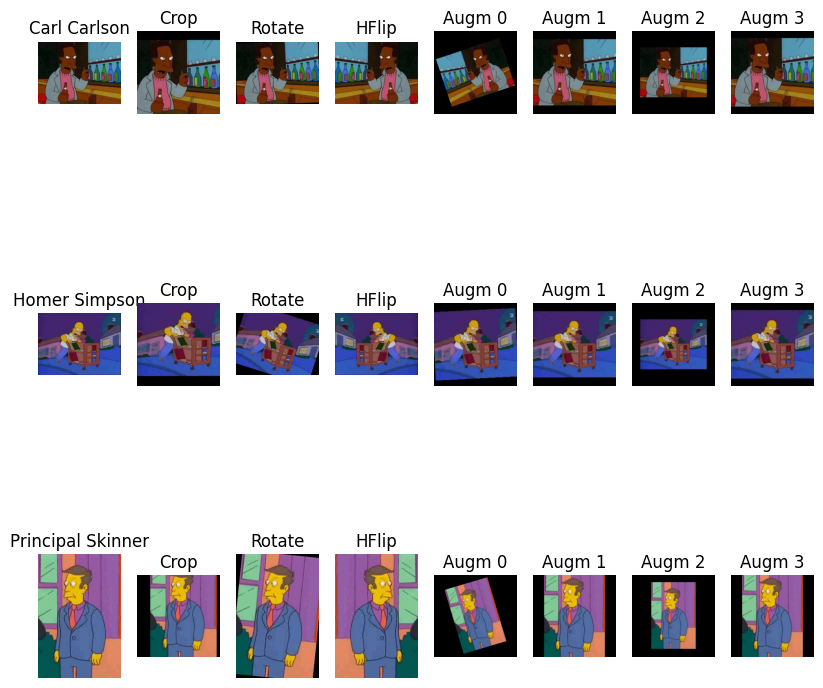

In [591]:
n_examples = 3

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = load_image(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(),\
                img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')